In [1]:
import flamp
import numpy as np
import numpy.linalg as lin
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import sparse
from tqdm import tqdm

import matrix_functions as mf
from fa_performance import fa_performance
from paper_plots import plot_convergence_curves

flamp.set_dps(300)  # compute with this many decimal digits precision


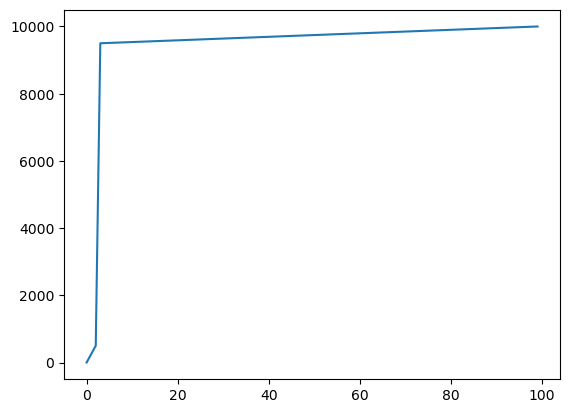

In [2]:
dim = 100
kappa = flamp.gmpy2.mpfr(1_000.)
lambda_min = flamp.gmpy2.mpfr(1.)

# a_diag = mf.flipped_model_spectrum(dim, kappa, 50, lambda_1=lambda_min)
# a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_size=3, lambda_1=lambda_min)
# a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_size=1, high_cluster_width=0.01, lambda_1=lambda_min)
# a_diag = mf.utils.linspace(lambda_min, kappa * lambda_min, num=dim)
# a_diag = mf.model_spectrum(dim, kappa, .9, lambda_1=lambda_min)
# a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_width=0.001, high_cluster_width=0.05, low_cluster_size=5, lambda_1=lambda_min)
# a_diag = mf.geometric_spectrum(dim, kappa, rho=1e-5, lambda_1=lambda_min)
# a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_width=0.001, high_cluster_width=0.001, low_cluster_size=dim//2, lambda_1=lambda_min)

# Tyler's idea
# a_diag = np.concatenate((flamp.zeros(dim//5), flamp.ones(dim//5), 2*flamp.ones(dim//5), 3*flamp.ones(dim//5), 4*flamp.ones(dim//5)))
# a_diag += 0.1 + np.random.randn(dim)
# a_diag = np.sort(np.abs(a_diag))
# a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_size=1, high_cluster_width=0.1)

# Chris and my idea
low_size = 3
a_diag = mf.two_cluster_spectrum(dim, kappa, low_cluster_size=low_size, low_cluster_width=0.05, high_cluster_width=0.05)

plt.plot(a_diag)

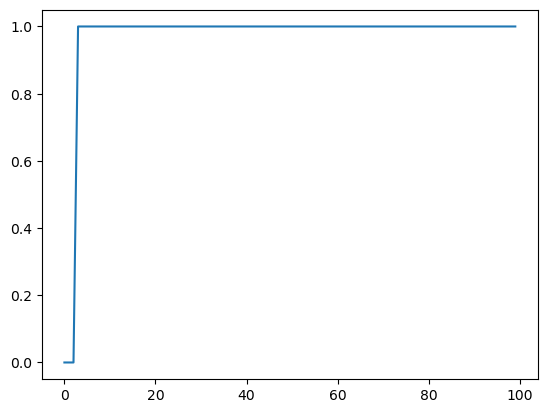

In [3]:
denom_deg = 2
def f(x):
    return x**(-denom_deg)
f.degree = (0, 2)

# mu = a_diag[:-1] + np.diff(a_diag) / 2
# mu = a_diag[:-1] + np.diff(a_diag).min() / 2
# mu = a_diag[1:] - np.diff(a_diag).min()/2
# b = mf.start_vec(a_diag, mu)

b = flamp.ones(dim)
# b = mf.two_cluster_spectrum(dim, kappa, low_cluster_size=1, high_cluster_width=0, lambda_1=lambda_min)
# b = a_diag
b[:low_size] = flamp.gmpy2.mpfr(1e-5)

plt.plot(b)

# size of Krylov subspace
# ks = list(range(1, dim, 10))  # + [dim]
ks = list(range(1, 30))


In [4]:
results = fa_performance(f, a_diag, b, ks, relative_error=True)


100%|██████████| 29/29 [00:00<00:00, 37751.34it/s]


In [ ]:
krylov_optimal_label = r"$||\mathrm{opt}_k(I) - f(A)b||_2$"
lanczos_label = r"$||\mathrm{lan}_k - f(A)b||_2$"
optimality_ratios = results[lanczos_label] / results[krylov_optimal_label]
sns.lineplot(data=optimality_ratios).set(
    xlabel="Number of matrix-vector products ($k$)",
    ylabel="Optimality Ratio"
);
optimality_ratios.astype(float).describe()

In [ ]:
print(f"Spike is at k={optimality_ratios.index[np.argmax(optimality_ratios)]}")

In [ ]:
plot_convergence_curves(results, "Relative Error", "Number of matrix-vector products ($k$)", title=None, ax=None)

plt.savefig('output/convergence.svg')

In [ ]:
A_decomp = mf.LanczosDecomposition.fit(mf.DiagonalMatrix(a_diag), b, max(ks), reorthogonalize=True)

In [ ]:
min_ritz = pd.Series(index=ks, dtype=np.dtype('O'))
second_ritz = pd.Series(index=ks, dtype=np.dtype('O'))
for k in ks:
    min_ritz.loc[k] = A_decomp.prefix(k).ritz_values().min()
    if k > 1: second_ritz.loc[k] = A_decomp.prefix(k).ritz_values()[1]

In [ ]:
sns.lineplot(data=min_ritz).set(
    xlabel="Number of matrix-vector products ($k$)",
    ylabel="Smallest Ritz Value"
);

In [ ]:
min_ritz

In [ ]:
second_ritz

# Detritus

In [ ]:
# import baryrat

# running_best_rational_bound = np.inf
# best_rational_bounds = []
# for k in range(99):
#     if k >= 2:
#         ##### WARNING! DON"T HARD CODE THE FUNCTION OK!
#         # aaa_interpolant = baryrat.aaa(np.array(spectrum_discritization, float), np.sqrt, mmax=(k//2))
#         # error = mf.norm(aaa_interpolant(spectrum_discritization) - np.array(f_spectrum_discritization, float), ord=np.inf)
#         # deg_k_error = (kappa ** (k//2)) * error
#         inv_sqrt = tyler_inv_sqrt((k//2), spectrum_discritization.min(), spectrum_discritization.max())
#         zolotarev_interpolant = lambda x: 1./inv_sqrt(x)
#     else:
#         deg_k_error = np.inf

#     running_best_rational_bound = min(running_best_rational_bound, deg_k_error)
#     best_rational_bounds.append(running_best_rational_bound)

# results['rational'] = np.array([min(best_rational_bound[:(k+1)]) for k in ks], dtype=float)

In [ ]:
# rational_bound_all_q = []
# for q in range(2,20):
#     rq_inv_sqrt = tyler_inv_sqrt(q, lambda_min, lambda_max)
#     rational_bound_q = []
#     for k in ks:
#         rational_approx_error = mf.norm(f(spectrum_discritization) - 1./rq_inv_sqrt(spectrum_discritization), ord=np.inf)
#         _, residual = flamp.qr_solve(krylov_basis[:, :k], mf.diagonal_fa(rq_inv_sqrt, a_diag, x), res=True) # uh-oh, this is 2-norm optimal, not A-norm optimal
#         krylov_error = mf.norm(residual, ord=np.inf)
#         rational_bound_q.append(rational_approx_error + (kappa ** q) * krylov_error)
#     rational_bound_all_q.append(rational_bound_q)

# results['other'] = np.array(rational_bound_all_q, float).min(axis=0)